# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 06.10.2021

Мягкий дедлайн: 23:59MSK 25.10.2021

Жесткий дедлайн: 23:59MSK 28.10.2021

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит предсказывать год выпуска песни по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [98]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision
from IPython.display import clear_output
from torch import nn, optim
from torchvision import transforms
from tqdm.auto import tqdm, trange
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [99]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2021-10-24 05:56:42--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211011981 (201M) [application/x-httpd-php]
Saving to: ‘data.txt.zip’

data.txt.zip        100%[===================>] 201.24M  55.9MB/s    in 4.0s    

2021-10-24 05:56:46 (50.5 MB/s) - ‘data.txt.zip’ saved [211011981/211011981]



In [100]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.08960,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.72670,1.36790,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,...,-25.38187,-3.90772,13.29258,41.55060,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.59110,-8.30657,7.93706,-10.73660,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.12450,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,457.41175,777.15347,415.64880,746.47775,366.45320,317.82946,273.07917,141.75921,317.35269,19.48271,-65.25496,162.75145,135.00765,-96.28436,-86.87955,17.38087,45.90742,32.49908,-32.85429,45.10830,26.84939,-302.57328,-41.71932,-138.85034,...,28.55107,1.52298,70.99515,-43.63073,-42.55014,129.82848,79.95420,-87.14554,-45.75446,-65.82100,-43.90031,-19.45705,12.59163,-407.64130,42.91189,12.15850,-88.37882,42.25246,46.49209,-30.17747,45.98495,130.47892,13.88281,-4.00055,17.85965,-18.32138,-87.99109,14.37524,-22.70119,-58.81266,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804,7.46586,699.54544,1016.00954,594.06748,355.73663,507.39931,387.69910,287.15347,112.37152,161.68928,144.14353,199.29693,-4.24359,-297.00587,-148.36392,-7.94726,-18.71630,12.77542,-25.37725,9.71410,0.13843,26.79723,6.30760,28.70107,-74.89005,-289.19553,-166.26089,...,18.50939,16.97216,24.26629,-10.50788,-8.68412,54.75759,194.74034,7.95966,-18.22685,0.06463,-2.63069,26.02561,1.75729,-262.36917,-233.60089,-2.50502,-12.14279,81.37617,2.07554,-1.82381,183.65292,22.64797,-39.98887,43.37381,-31.56737,-4.88840,-36.53213,-23.94662,-84.19275,66.00518,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,6.63016,-3.35142,37.64085,2174.08189,697.43346,459.24587,742.78961,229.30783,387.89697,249.06662,245.89870,176.20527,98.82222,150.97286,78.49057,-62.00282,43.49659,-96.42719,-108.96608,14.22854,14.54178,-23.55608,-39.36953,-43.59209,20.83714,35.63919,-181.34947,-93.66614,-90.55616,...,4.56917,-37.32280,4.15159,12.24315,35.02697,-178.89573,82.46573,-20.49425,101.78577,-19.77808,-21.52657,3.36303,-11.63176,51.55411,-50.57576,-28.14755,-83.15795,-7.35260,-22.11505,1.18279,-122.70467,150.57360,24.37468,41.19821,-37.04318,-28.72986,162.19614,22.18309,-8.63509,85.23416,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,1.60923,2.19223,47.32082,894.28471,809.86615,318.78559,435.04497,341.61467,334.30734,322.99589,190.61921,235.84715,96.89517,210.58870,5.60463,-199.63958,204.85812,-77.17695,-65.79741,-6.95097,-12.15262,-3.85410,20.68990,-20.30480,37.15045,11.20673,-124.09519,-295.98542,-33.31169,...,45.25506,10.42226,27.88782,-17.12676,-31.54772,-76.86293,41.17343,-138.32535,-53.96905,-21.30266,-24.87362,-2.46595,-4.05003,-56.51161,-34.56445,-5.07092,-47.75605,64.81513,-97.42948,-12.59418,55.23699,28.85657,54.53513,-31.97077,20.03279,-8.07892,-55.12617,26.58961,-10.27183,-30.64232,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.6

In [101]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

In [ ]:
clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 1e+1, 1e+2]).fit(X_train, y_train)

In [ ]:
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

In [ ]:
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

In [ ]:
rmse_train

9.552822968138988

In [ ]:
rmse_test

9.510160583791397

In [ ]:
r2_score(y_test, y_pred_test)

0.2319962363682243

## Задание 1. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из ячейки ниже.



In [102]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться следующими сигнатурами функций. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [103]:
set_random_seed(1)

In [104]:
scaler_x = StandardScaler().fit(X_train)
train_x = scaler_x.transform(X_train)
test_x = scaler_x.transform(X_test)

In [105]:
scaler_y = StandardScaler().fit(y_train.reshape(-1, 1))
train_y = scaler_y.transform(y_train.reshape(-1, 1))
test_y = scaler_y.transform(y_test.reshape(-1, 1))

In [106]:
class RandomDataset(torch.utils.data.Dataset):
    
    def __init__(self, x, y):
        self.x=x
        self.y=y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return {'sample': torch.tensor(self.x[idx, :], dtype=torch.float), 'target': self.y[idx]}

In [107]:
trainset = RandomDataset(train_x, train_y)

In [108]:
testset = RandomDataset(test_x, test_y)

In [109]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

In [110]:
model = nn.Sequential(
    nn.Linear(90, 160),
    #nn.BatchNorm1d(150),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(160, 110),
    nn.BatchNorm1d(110),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(110, 90),
    nn.BatchNorm1d(90),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(90, 1))
model = model.double()
model

Sequential(
  (0): Linear(in_features=90, out_features=160, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=160, out_features=110, bias=True)
  (4): BatchNorm1d(110, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=110, out_features=90, bias=True)
  (8): BatchNorm1d(90, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU()
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=90, out_features=1, bias=True)
)

In [111]:
optimizer = optim.SGD(model.parameters(), lr=0.0006, momentum=0.9)

In [112]:
criterion = nn.MSELoss()

In [113]:
def plot_history(train_history, val_history, title="loss"):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label="train", zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c="orange", label="val", zorder=2)
    plt.xlabel("train steps")
    
    plt.legend(loc="best")
    plt.grid()

    plt.show()

In [114]:
def train(model, optimizer, criterion, train_loader, test_loader, n_epochs):
    train_loss, test_epoch_loss = [], []
    '''
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    '''
    for epoch in range(n_epochs):
        # тренировка
        train_loss = []
        for batch in tqdm(train_loader, desc=f"training, epoch {epoch}", leave=False):
            sample = batch['sample'].double()
            target = batch['target'].double()
            sample, target = sample.to('cpu'), target.to('cpu')
            model.train()
            y_pred = model(sample)
            loss = criterion(y_pred, target)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss.append(torch.sqrt(loss.data) * np.sqrt(scaler_y.var_) + 1)

        # валидация
        test_loss = []
        model.eval()

        for batch in tqdm(test_loader, desc=f"testing, epoch {epoch}", leave=False):
            sample = batch['sample'].double()
            target = batch['target'].double()
            sample, target = sample.to('cpu'), target.to('cpu')
                
            y_pred = model(sample)
            loss = criterion(y_pred, target)
            test_loss.append(torch.sqrt(loss.data) * np.sqrt(scaler_y.var_))
            
        test_epoch_loss.append(np.mean(test_loss))

        plot_history(train_loss, test_epoch_loss, "loss")

        print('test loss:', test_epoch_loss[-1])
        print('epoch:', epoch + 1)


def test(model, criterion, test_loader):
    '''
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    '''
    predict = torch.Tensor([])
    for batch in tqdm(test_loader):
        x_test = batch['sample'].double()
        y_pred = model(x_test)
        predict = torch.cat((predict, y_pred),0)
    return predict

In [115]:
assert test(model, criterion, test_loader).shape[0] == y_test.shape[0]

  0%|          | 0/404 [00:00<?, ?it/s]

training, epoch 0:   0%|          | 0/7246 [00:00<?, ?it/s]

testing, epoch 0:   0%|          | 0/404 [00:00<?, ?it/s]

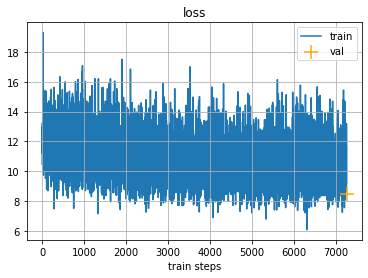

test loss: 8.478072217483986
epoch: 1


training, epoch 1:   0%|          | 0/7246 [00:00<?, ?it/s]

testing, epoch 1:   0%|          | 0/404 [00:00<?, ?it/s]

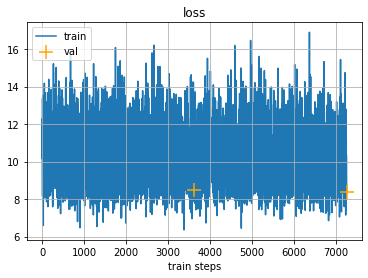

test loss: 8.381694922091999
epoch: 2


training, epoch 2:   0%|          | 0/7246 [00:00<?, ?it/s]

testing, epoch 2:   0%|          | 0/404 [00:00<?, ?it/s]

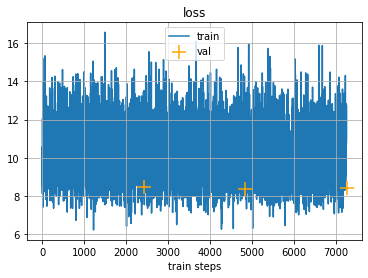

test loss: 8.444243322936742
epoch: 3


training, epoch 3:   0%|          | 0/7246 [00:00<?, ?it/s]

testing, epoch 3:   0%|          | 0/404 [00:00<?, ?it/s]

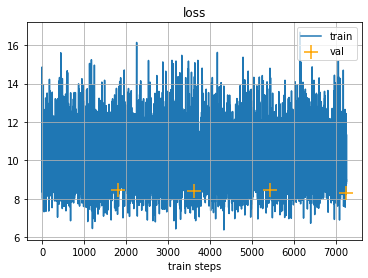

test loss: 8.312401918855825
epoch: 4


training, epoch 4:   0%|          | 0/7246 [00:00<?, ?it/s]

testing, epoch 4:   0%|          | 0/404 [00:00<?, ?it/s]

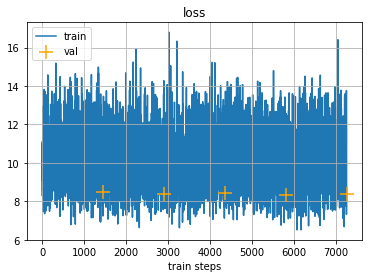

test loss: 8.35884954057522
epoch: 5


training, epoch 5:   0%|          | 0/7246 [00:00<?, ?it/s]

testing, epoch 5:   0%|          | 0/404 [00:00<?, ?it/s]

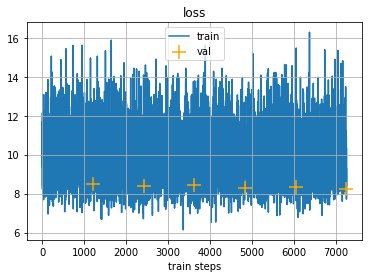

test loss: 8.236204376601265
epoch: 6


training, epoch 6:   0%|          | 0/7246 [00:00<?, ?it/s]

testing, epoch 6:   0%|          | 0/404 [00:00<?, ?it/s]

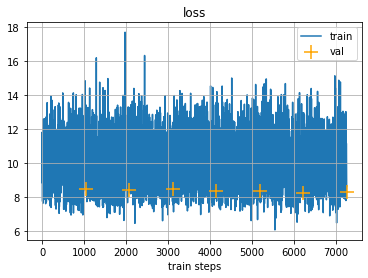

test loss: 8.252985102930852
epoch: 7


training, epoch 7:   0%|          | 0/7246 [00:00<?, ?it/s]

testing, epoch 7:   0%|          | 0/404 [00:00<?, ?it/s]

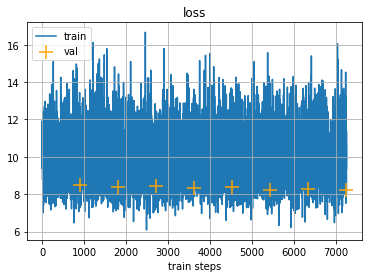

test loss: 8.226849977201375
epoch: 8


training, epoch 8:   0%|          | 0/7246 [00:00<?, ?it/s]

testing, epoch 8:   0%|          | 0/404 [00:00<?, ?it/s]

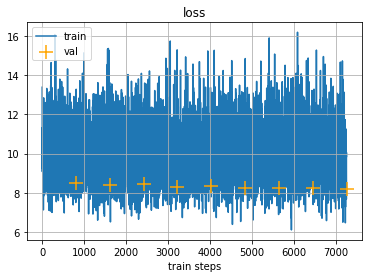

test loss: 8.191970497104991
epoch: 9


training, epoch 9:   0%|          | 0/7246 [00:00<?, ?it/s]

testing, epoch 9:   0%|          | 0/404 [00:00<?, ?it/s]

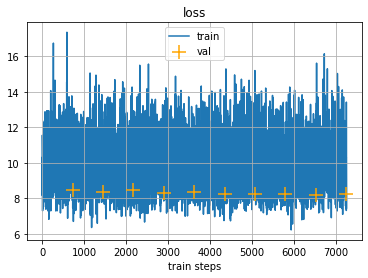

test loss: 8.219189152067068
epoch: 10


training, epoch 10:   0%|          | 0/7246 [00:00<?, ?it/s]

testing, epoch 10:   0%|          | 0/404 [00:00<?, ?it/s]

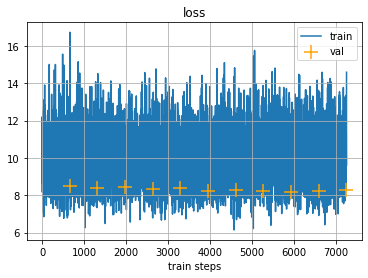

test loss: 8.25723906390754
epoch: 11


training, epoch 11:   0%|          | 0/7246 [00:00<?, ?it/s]

testing, epoch 11:   0%|          | 0/404 [00:00<?, ?it/s]

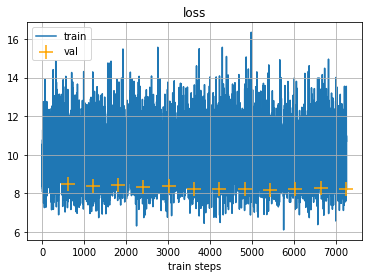

test loss: 8.2141158621569
epoch: 12


training, epoch 12:   0%|          | 0/7246 [00:00<?, ?it/s]

testing, epoch 12:   0%|          | 0/404 [00:00<?, ?it/s]

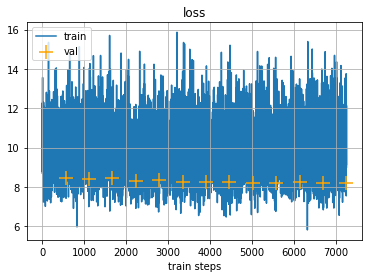

test loss: 8.215016824905792
epoch: 13


training, epoch 13:   0%|          | 0/7246 [00:00<?, ?it/s]

testing, epoch 13:   0%|          | 0/404 [00:00<?, ?it/s]

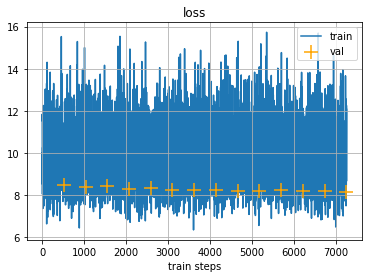

test loss: 8.1511361493785
epoch: 14


training, epoch 14:   0%|          | 0/7246 [00:00<?, ?it/s]

testing, epoch 14:   0%|          | 0/404 [00:00<?, ?it/s]

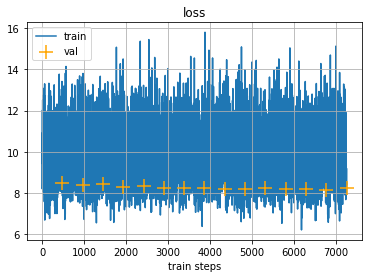

test loss: 8.238088133665865
epoch: 15


training, epoch 15:   0%|          | 0/7246 [00:00<?, ?it/s]

testing, epoch 15:   0%|          | 0/404 [00:00<?, ?it/s]

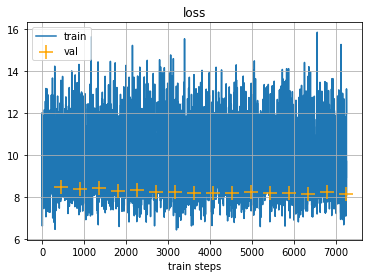

test loss: 8.170322024654974
epoch: 16


training, epoch 16:   0%|          | 0/7246 [00:00<?, ?it/s]

testing, epoch 16:   0%|          | 0/404 [00:00<?, ?it/s]

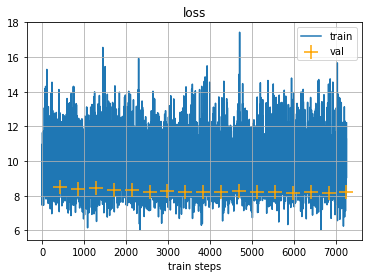

test loss: 8.214503655390104
epoch: 17


training, epoch 17:   0%|          | 0/7246 [00:00<?, ?it/s]

testing, epoch 17:   0%|          | 0/404 [00:00<?, ?it/s]

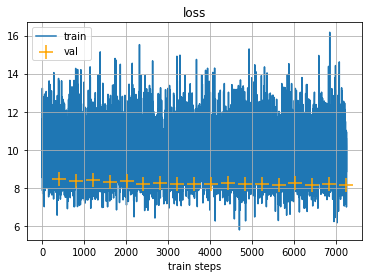

test loss: 8.178802669418353
epoch: 18


training, epoch 18:   0%|          | 0/7246 [00:00<?, ?it/s]

testing, epoch 18:   0%|          | 0/404 [00:00<?, ?it/s]

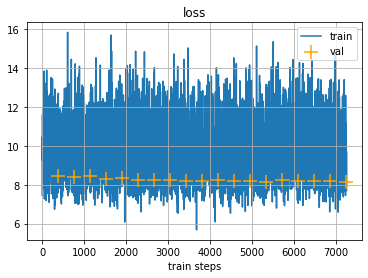

test loss: 8.141098904703892
epoch: 19


training, epoch 19:   0%|          | 0/7246 [00:00<?, ?it/s]

testing, epoch 19:   0%|          | 0/404 [00:00<?, ?it/s]

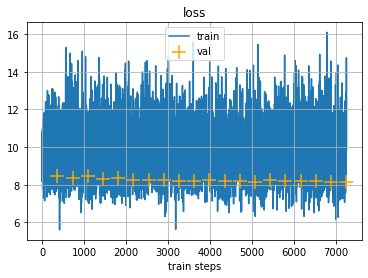

test loss: 8.143379103475777
epoch: 20


In [116]:
train(model, optimizer, criterion, train_loader, test_loader, n_epochs=20)

In [94]:
np.sqrt(mean_squared_error(test(model, criter ion, test_loader).detach().numpy(), test_y)) * np.sqrt(scaler_y.var_)

  0%|          | 0/404 [00:00<?, ?it/s]

array([8.82388034])

In [118]:
np.sqrt(mean_squared_error(test(model, criterion, test_loader).detach().numpy(), test_y)) * np.sqrt(scaler_y.var_)

  0%|          | 0/404 [00:00<?, ?it/s]

array([8.80897911])

In [97]:
np.sqrt(mean_squared_error(test(model, criterion, test_loader).detach().numpy(), test_y)) * np.sqrt(scaler_y.var_)

  0%|          | 0/404 [00:00<?, ?it/s]

array([8.753478])

## Задание 2. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

In [ ]:
# YOUR CODE HERE (－.－)...zzzZZZzzzZZZ